In [2]:
import starepandas
import pystare
import pickle
import numpy
import geopandas
import matplotlib.pyplot as plt
import datetime

In [3]:
start = datetime.datetime.now()

In [4]:
data_dir = '/tablespace/xcal/'
with open(f'{data_dir}/pickles/featuredb.pickle', 'rb') as f:
    features = pickle.load( f)

# Load US States

In [5]:
!wget https://www2.census.gov/geo/tiger/TIGER2019/STATE/tl_2019_us_state.zip

--2022-04-20 18:01:12--  https://www2.census.gov/geo/tiger/TIGER2019/STATE/tl_2019_us_state.zip
Resolving www2.census.gov (www2.census.gov)... 23.59.203.141, 2600:1406:5800:3ab::208c, 2600:1406:5800:380::208c
Connecting to www2.census.gov (www2.census.gov)|23.59.203.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘tl_2019_us_state.zip.5’

tl_2019_us_state.zi     [    <=>             ]   8.90M  11.2MB/s    in 0.8s    

2022-04-20 18:01:13 (11.2 MB/s) - ‘tl_2019_us_state.zip.5’ saved [9332961]



In [6]:
states = geopandas.read_file('tl_2019_us_state.zip')

In [7]:
states = starepandas.STAREDataFrame(states)
sids = states.make_sids(n_workers=50, resolution=10)
states.set_sids(sids, inplace=True)
trixels = states.make_trixels(n_workers=50, wrap_lon=False)
states.set_trixels(trixels, inplace=True)
states.split_antimeridian(inplace=True)

In [8]:
alabama = states[states['NAME']=='Alabama']
alabama_sids = alabama.sids.iloc[0]

<AxesSubplot:>

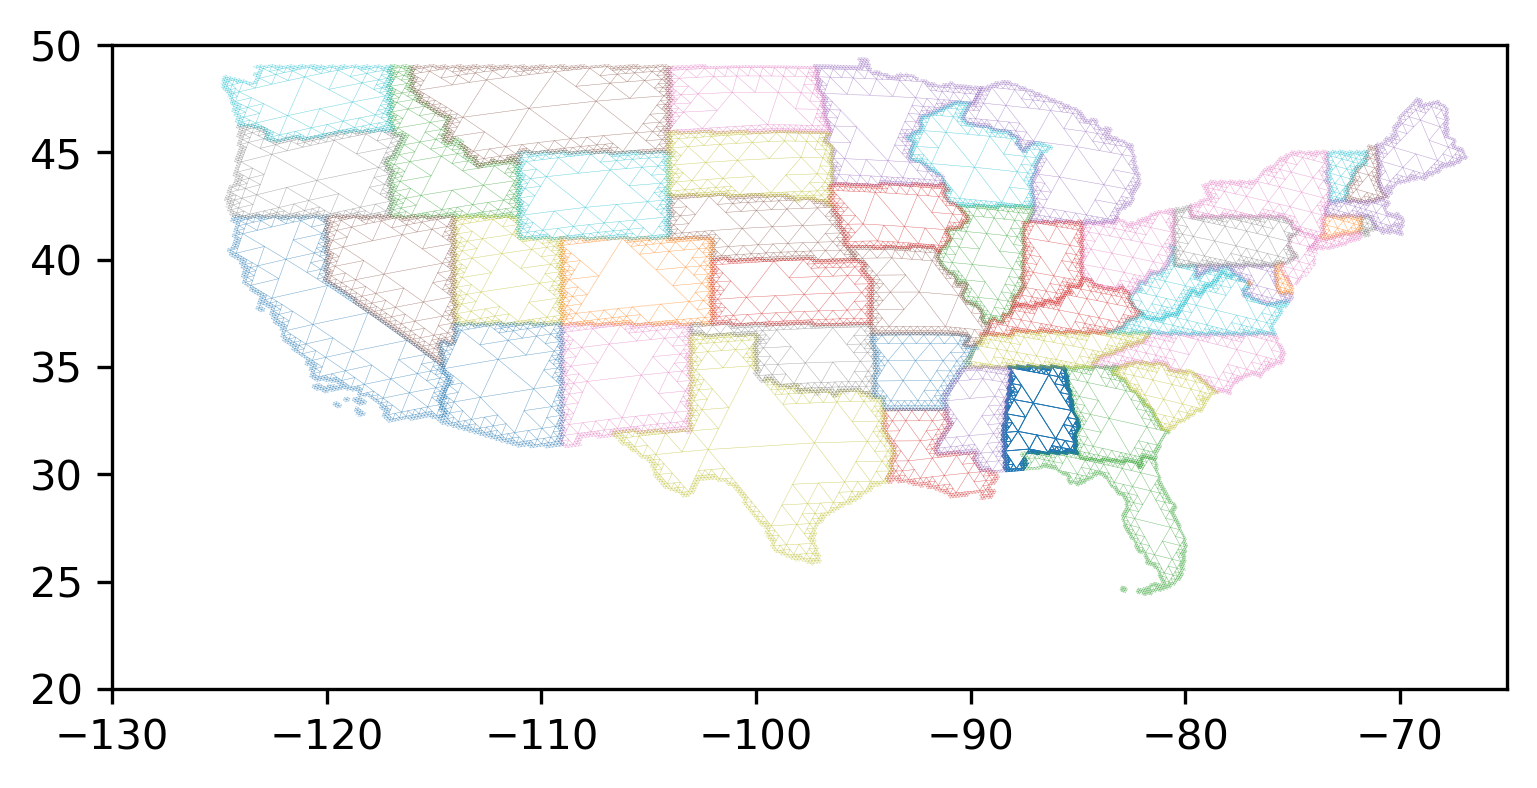

In [9]:
fig = plt.figure(figsize=(6, 3), dpi=300)
ax = fig.add_subplot()

ax.set_xlim(-130, -65)
ax.set_ylim(20, 50)

alabama.plot(ax=ax, linewidth=0.2)
states.plot(ax=ax, column='NAME', linewidth=0.1, alpha=0.4)

# Pull out events intersecting Alabama

In [10]:
intersects = features.stare_intersects(alabama_sids, n_workers=60)
features[intersects].label.unique()

array([17, 65, 74, 91, 94], dtype=int32)

# Inspecting the first event (17)

In [11]:
event_17 = features[features.label==17]

<AxesSubplot:>

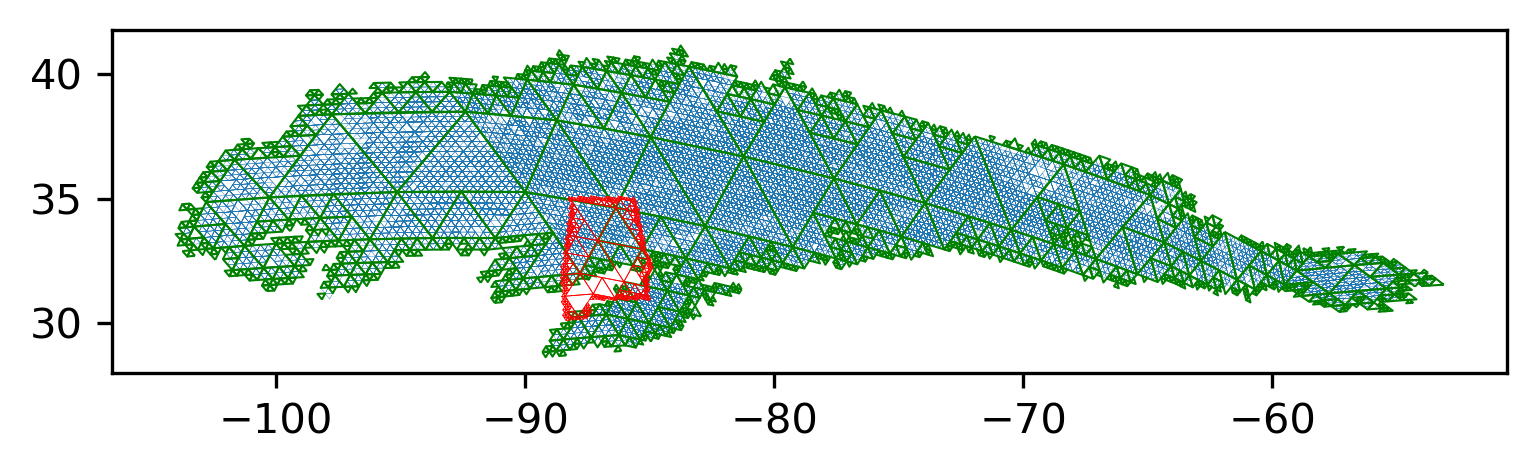

In [12]:
fig = plt.figure(figsize=(6, 3), dpi=300)
ax = fig.add_subplot()

dissolved_sids = event_17.stare_dissolve()
dissolved_event = starepandas.STAREDataFrame(sids=[dissolved_sids])
trixels = dissolved_event.make_trixels()
dissolved_event.set_trixels(trixels, inplace=True)

dissolved_event.plot(ax=ax, zorder=2, linewidth=0.5, color='g')

event_17.plot(ax=ax, zorder=1, linewidth=0.1)
alabama.plot(ax=ax, zorder=3, color='r', linewidth=0.2)

# Calculating precip 

## Precio for the whole event

In [21]:
tot_precip = event_17.tot_precip.sum()
print(f'Total Precip: {tot_precip:,.2f} cubic meters')

Total Precip: 61,980,755,210.15 cubic meters


## Getting timeframes of the event that intersected Alabama

In [17]:
intersects = event_17.stare_intersects(alabama_sids)
over_alabama = event_17.reset_index()[intersects]

## Getting the cells/sids/trixels that intersect Alabama

In [18]:
over_alabama['in'] =  over_alabama['sids'].apply(lambda row: pystare.intersects(alabama_sids, row))

## Calculating Total Precip over alabama

In [19]:
def calc_tot_precip(row):
    return (row['cell_areas']*row['precips']/1000/2*row['in']).sum()
    
over_alabama['precip_in_alabama'] = over_alabama.apply(lambda row: calc_tot_precip(row), axis=1)

In [22]:
alabama_precip = over_alabama['precip_in_alabama'].sum()
alabama_precip_share = alabama_precip/tot_precip * 100
print(f'Share of event 17 in Alabama is {alabama_precip_share:2.2f} %')

Share of event 17 in Alabama is 4.38 %


# Total Runtime

In [17]:
print(datetime.datetime.now()-start)

0:01:35.800970


In [15]:
event_17.timestamp.max()-event_17.timestamp.min()

Timedelta('2 days 12:30:00')

In [23]:
over_alabama.timestamp.max()-over_alabama.timestamp.min()

Timedelta('1 days 18:30:00')